In [1]:
import finite_diff as fd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from trace_ray import trace_ray_1D
from torch_helper import to_torch, to_torch_3D, torch_func, inner_product, angle
from scipy.special import airy
from scipy.signal import find_peaks
from rational_functions import fit_polynomial, fit_rational_func
from gauss_freud_quad import get_nodes_and_weights

import mgo

In [2]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

### Dispersion Relation

In [3]:
@torch_func
def D(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return - x - k**2

### Exact Solution gives Initial Conditions

In [4]:
def Ai(x):
    ai, *_ = airy(x)
    return ai

def Bi(x):
    _, _, bi, _ = airy(x)
    return bi

xi = np.linspace(-8, 0, 1000)
E_ex = Ai(xi) # Exact solution is Airy function

# Set ICs from Airy function
first_peak_ind = find_peaks(E_ex)[0][0]
x0  = xi[first_peak_ind]
phi0 = E_ex[first_peak_ind]

x1 = xi[find_peaks(E_ex)[0][1]]
phi1 = E_ex[find_peaks(E_ex)[0][1]]

### Ray Tracing

In [5]:
ND = 1
nt = 1000

xs = np.zeros((nt, ND))
ks = np.zeros((nt, ND))
omega0 = 1.0

# ray tracing stops when it hits boundary, so we don't know
# exact number of timesteps before ray tracing has completed.
min_nt = nt

sol = trace_ray_1D(x0=x0, k0=np.sqrt(-x0), omega0=omega0, tmin=0, tmax=8, D=D, x_min=x0, tsteps=nt)
sol_nt = len(sol.t)
xs[:sol_nt, :] = sol.y[:ND].T
ks[:sol_nt, :] = sol.y[ND:].T
min_nt = np.min((sol_nt, min_nt))

# Clip all rays to the same number of time steps
nt = min_nt
t = sol.t[:min_nt]
xs = xs[:min_nt, :]
ks = ks[:min_nt, :]
zs = np.concatenate([xs, ks], axis=-1)

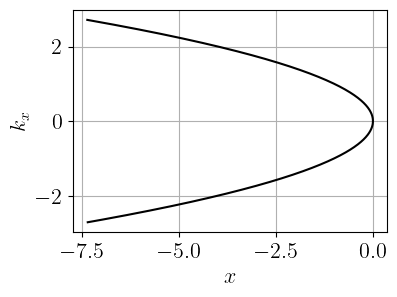

In [6]:
fig = plt.figure(figsize=(4,3))
plt.plot(xs, ks, 'k-')
plt.tight_layout()
plt.savefig('./plots/1D_MGO_airy_dispersion_manifold.png')
plt.savefig('./plots/1D_MGO_airy_dispersion_manifold.pdf')
# plt.xlim(-8, 0)
plt.xlabel(r'$x$')
plt.ylabel(r'$k_x$')
plt.grid()
plt.show()

In [7]:
i_caust = np.argmin(np.abs(ks[:, 0]))
t_save = t[i_caust] + np.array([-2.71, -2, -1, -0.3, -0.15, -0.1, -0.05, -0.01, 0, 2.71, 2, 1, 0.3, 0.15, 0.1, 0.05, 0.01])
i_save = [np.argmin(np.abs(t - t0)) for t0 in t_save]

In [19]:
branch_masks, ray_fields, results = mgo.get_mgo_field(t, zs, phi0=phi0, i_save=i_save,
    analytic_cont={'phase': {'fit_func': fit_polynomial, 'kwargs': {'deg': 6, 'exclude_degrees': [1]}},
                   'amplitude': {'fit_func': fit_rational_func, 'kwargs': {'L': 2, 'M': 4, 'optimize': False}}})

In [20]:
field = mgo.superpose_ray_fields(phi1, x1, xs, branch_masks, ray_fields)

In [21]:
xi = np.linspace(np.min(xs.squeeze()), np.max(xs.squeeze()), 1000)

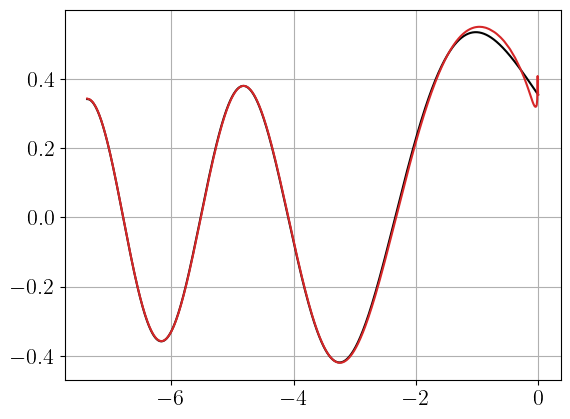

In [22]:
plt.plot(xi, Ai(xi), 'k-')
plt.plot(xi, field(xi), '-', color='tab:red')
plt.grid()
plt.show()

### Inspect Results

In [12]:
# Define analytical functions for comparison with numerical results
v_anal = lambda p: np.sqrt(1+4*(p**2))
f_anal = lambda eps, p: (
    (v_anal(p)**6 - (v_anal(p)**4 - 8*v_anal(p)*p*eps)**(3/2))/(96*(p**3))
    - v_anal(p)**3/(8*(p**2)) * eps + v_anal(p)**2/(4*p) * eps**2
    )
df_anal = lambda eps, p: v_anal(p)/(8*(p**2)) * (
    4*v_anal(p)*p*eps
    - v_anal(p)**2
    + (v_anal(p)**4 - 8*v_anal(p)*p*eps)**(1/2)
    )
ddf_anal = lambda eps, p: v_anal(p)**2/(2*p) * (1 - (v_anal(p)**4 - 8*v_anal(p)*p*eps)**(-1/2)) 
g_anal = lambda eps, p: (1/(2*np.pi)) * v_anal(p)/(v_anal(p)**4 - 8*v_anal(p)*p*eps)**(1/4)

Theta_anal = lambda eps, p: (
    (8*(p**4) - (v_anal(p)**4))
    / (8*(p**2) * v_anal(p)) * eps
    + (1/(4*p)) * (eps **2)
    + ((v_anal(p)**6) - (v_anal(p)**4 - 8 * p * v_anal(p) * eps)**(3/2))
    / (96*(p**3))
    )

In [13]:
C = lambda l, sigma_p, sigma_m, s_p, s_m: np.abs(l) * np.piecewise(l, [l <= 0, l > 0], [lambda l: np.exp(1j*sigma_m)/np.emath.sqrt(s_m), lambda l: np.exp(1j*sigma_p)/np.emath.sqrt(s_p)])
C_R = lambda l, sigma_p, sigma_m, s_p, s_m: np.real(C(l, sigma_p, sigma_m, s_p, s_m))
C_I = lambda l, sigma_p, sigma_m, s_p, s_m: np.imag(C(l, sigma_p, sigma_m, s_p, s_m))

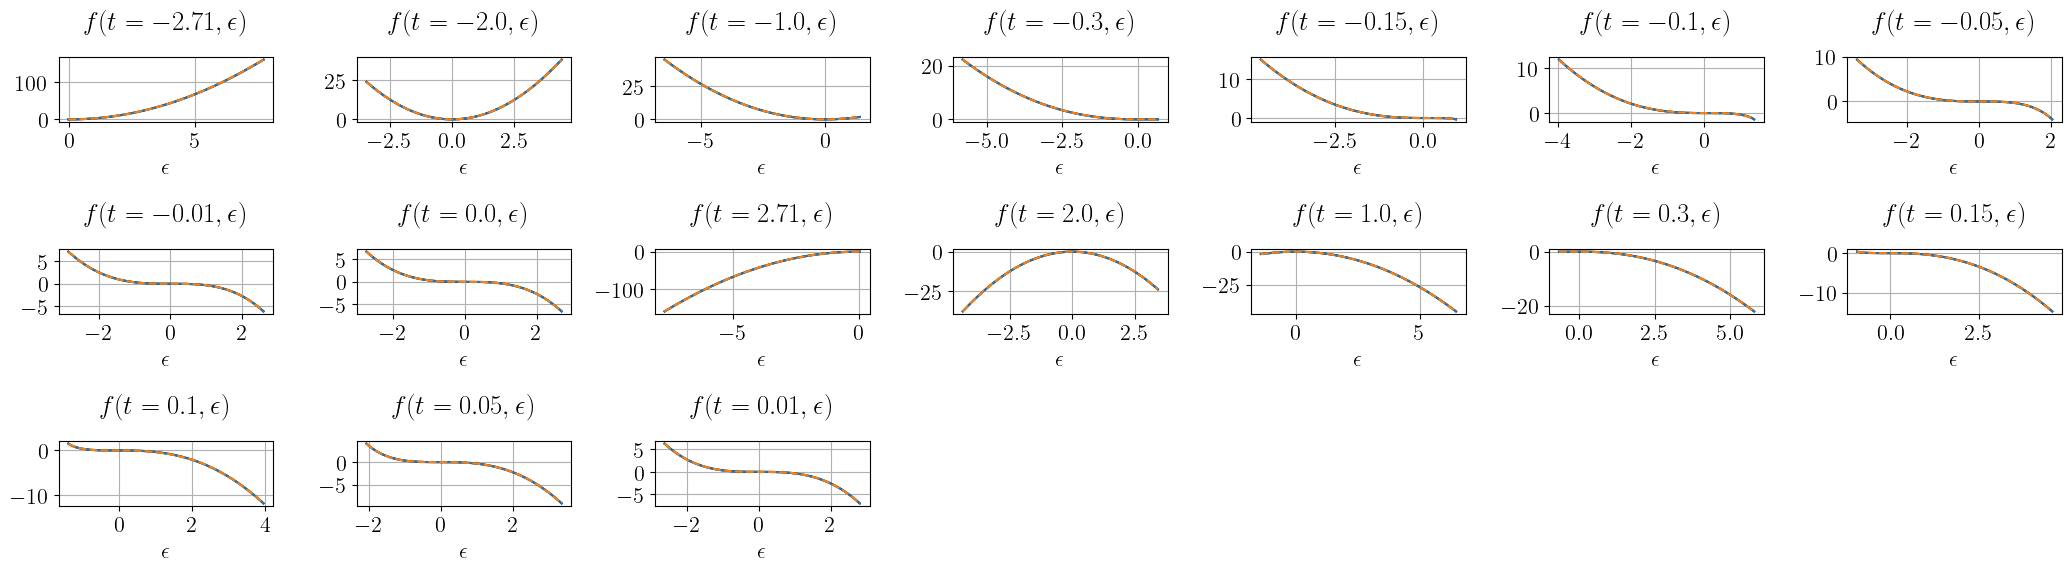

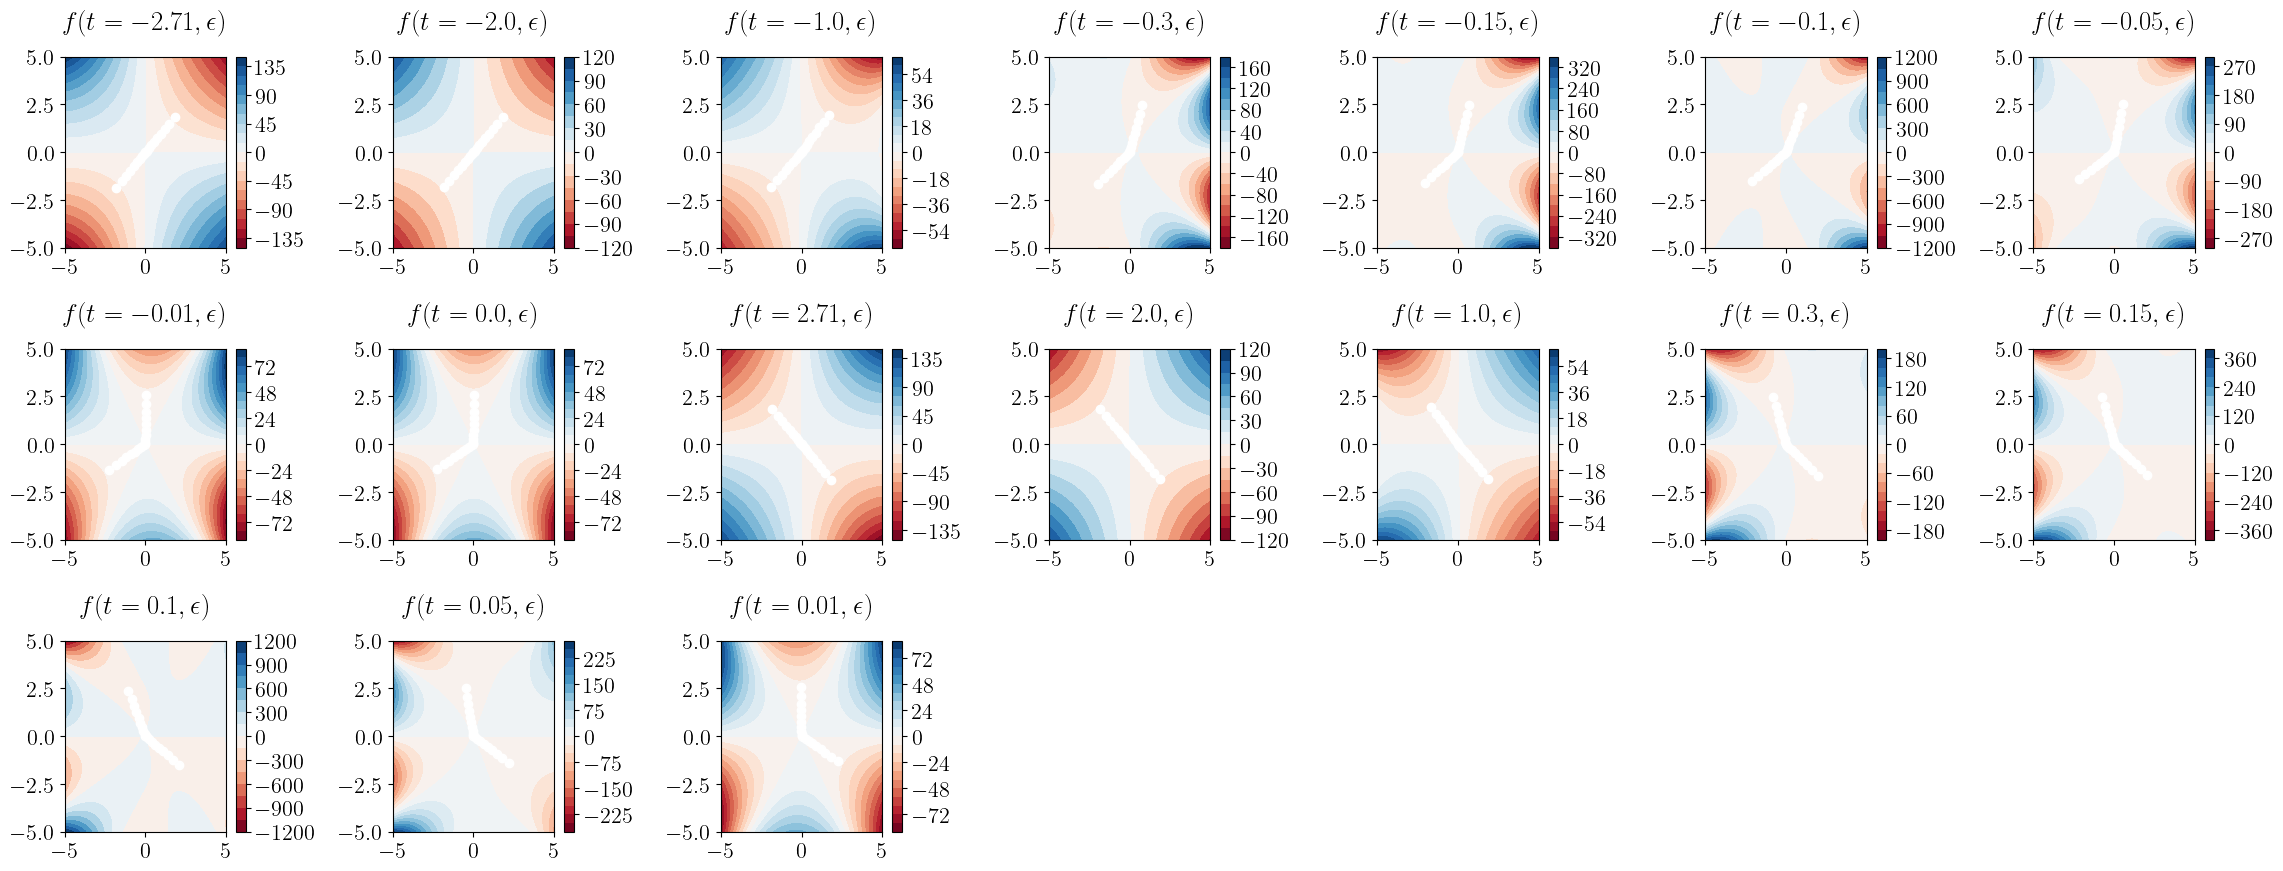

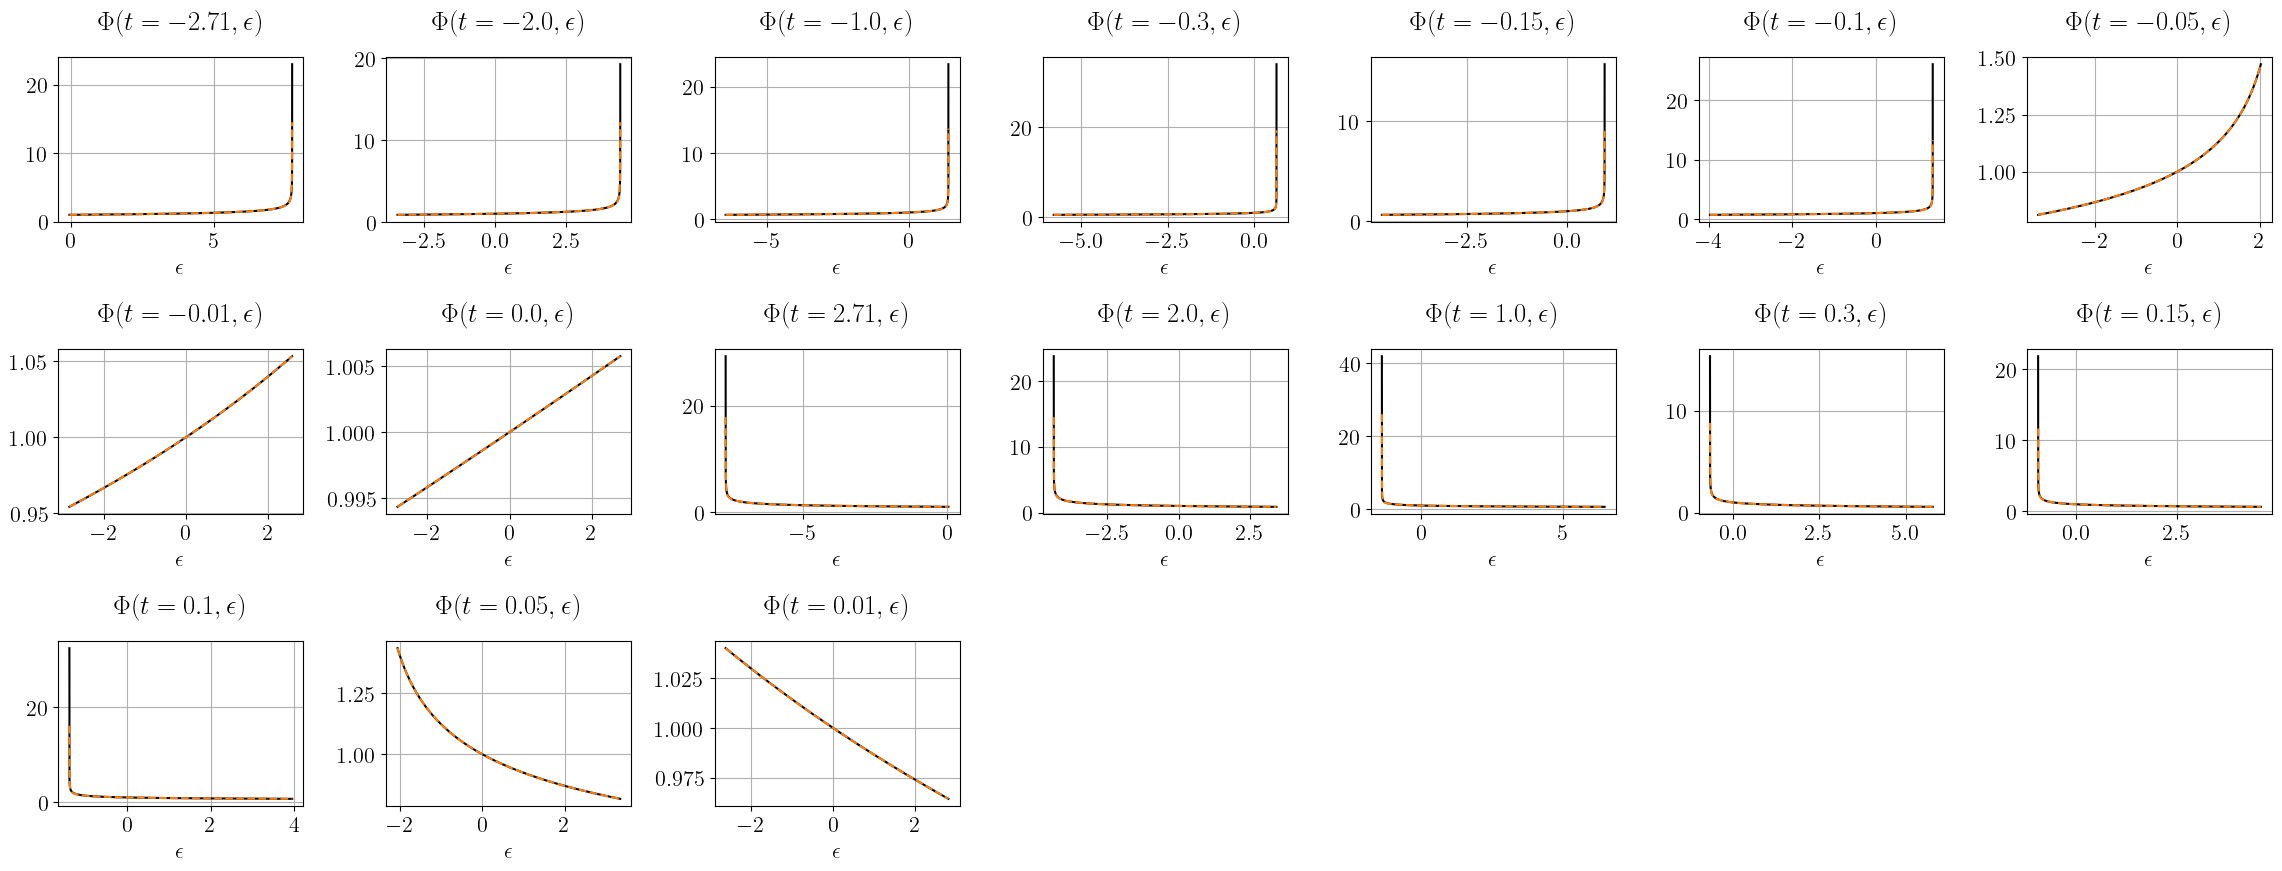

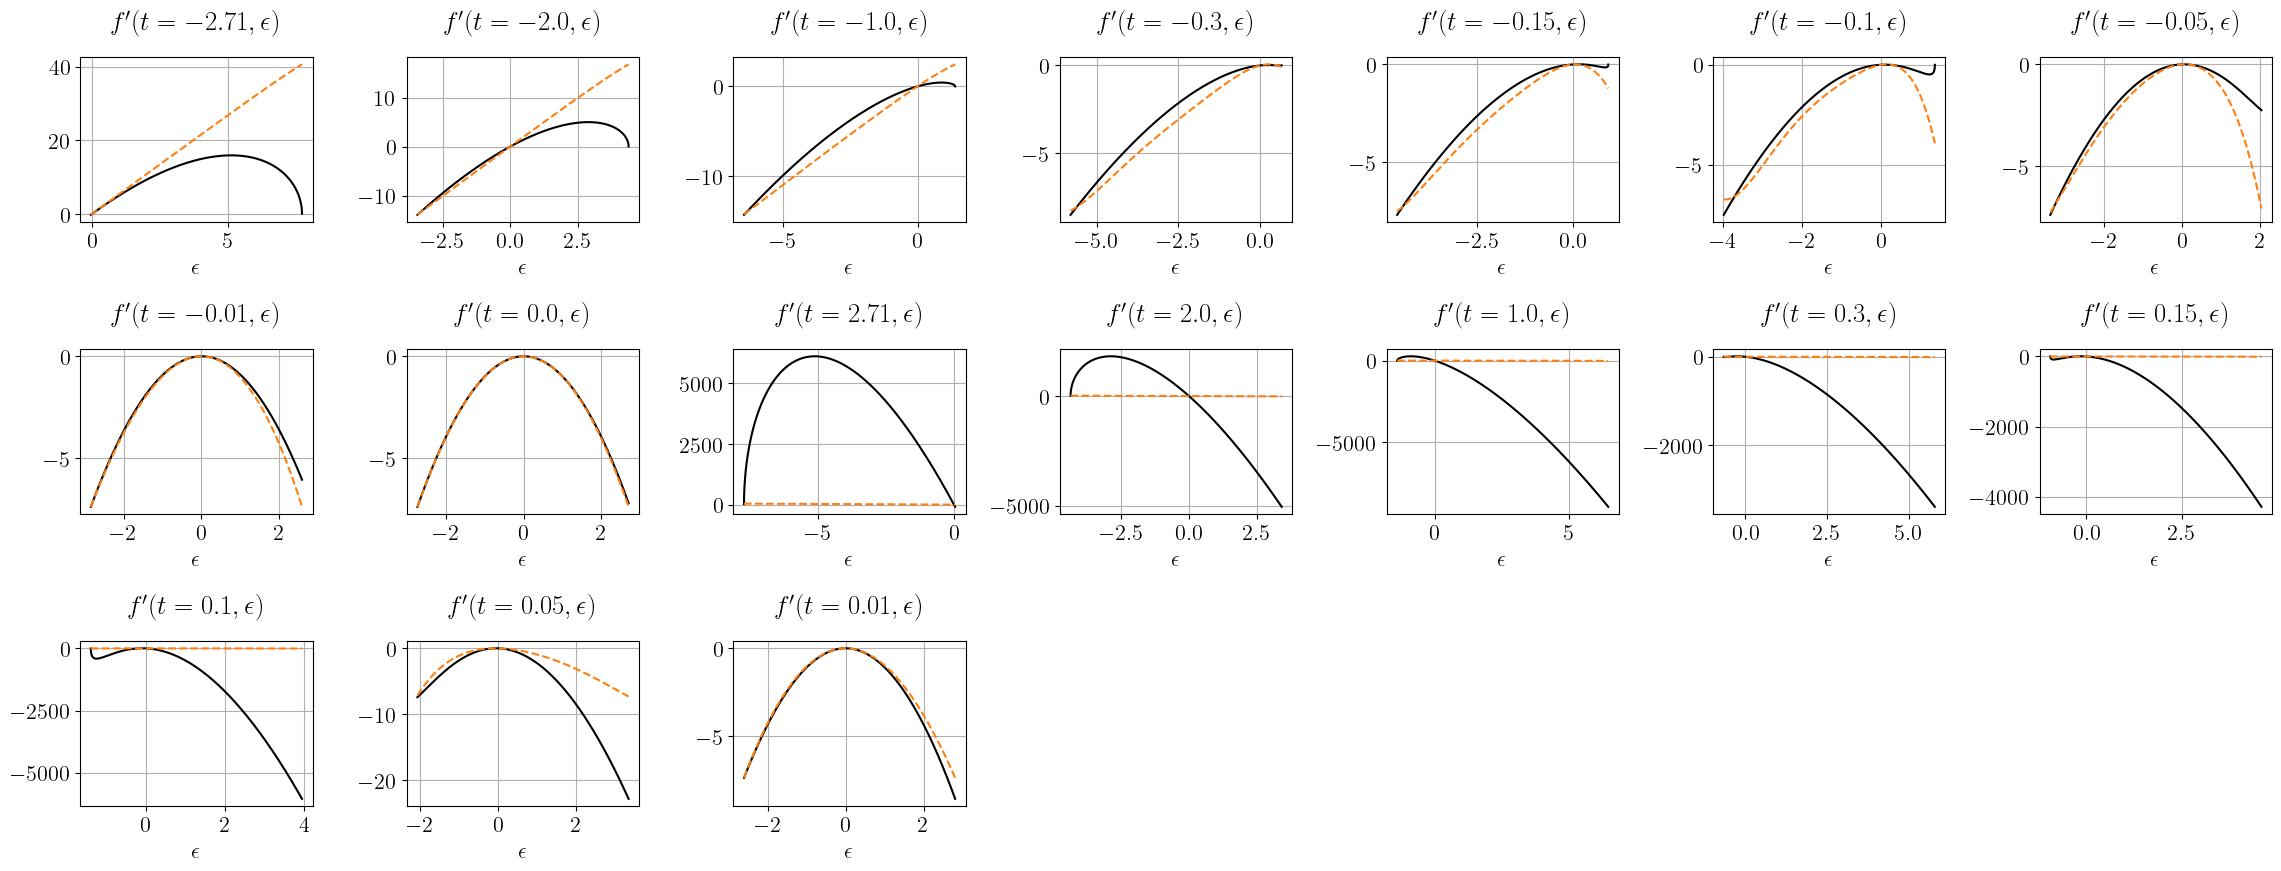

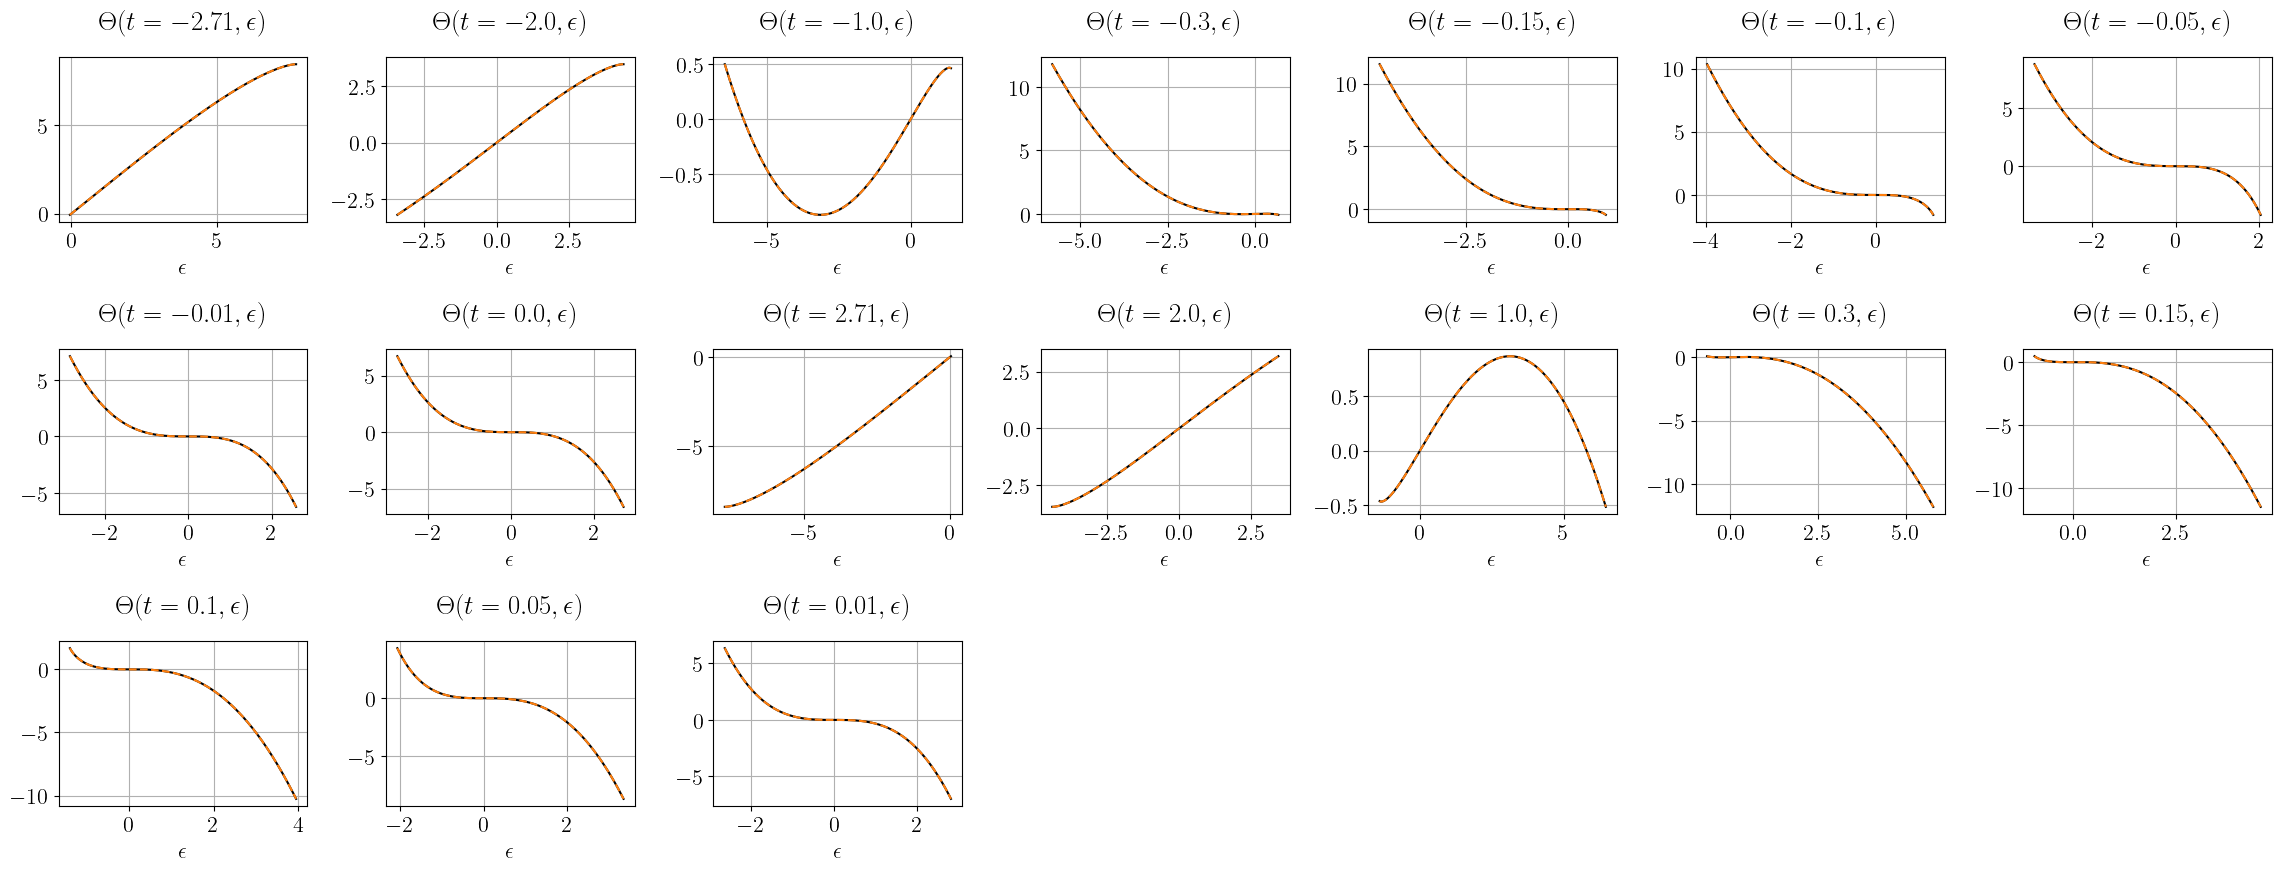

In [14]:
epsmax = np.round(np.mean([1/np.emath.sqrt(results[0]['s_m'][0]), 1/np.emath.sqrt(results[0]['s_p'][0])]), -3)

eps_R = np.linspace(-5,5, 1000)
eps_I = np.linspace(-5,5, 1000)
Eps_R, Eps_I = np.meshgrid(eps_R, eps_I)
Eps = Eps_R + 1j*Eps_I
l_j, _ = get_nodes_and_weights(n=10)
l_j = l_j.astype(np.complex_)

ncols, nrows = 7, 3
fig = plt.figure(1, figsize=(ncols*3,nrows*2))
fig2 = plt.figure(2, figsize=(ncols*3.3,nrows*3))
fig3 = plt.figure(3, figsize=(ncols*3.3,nrows*3))
fig4 = plt.figure(4, figsize=(ncols*3.3,nrows*3))
fig5 = plt.figure(5, figsize=(ncols*3.3,nrows*3))

for i, result in enumerate(results):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig.add_subplot(nrows, ncols, 1 + i)
    t1, it, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
    k = ks[it, 0]
    eps_rho = eps_rho.squeeze()
    ax.plot(eps_rho, f_t1, 'k-')
    ax.plot(eps_rho, f_anal(eps_rho, k), '-', color='tab:blue')
    ax.plot(eps_rho, f_fit(eps_rho), '--', color='tab:orange')
    ax.set_title(r'$f(t = ' + str(np.round(t1 - t[i_caust],2)) + r', \epsilon)$')
    ax.set_xlabel(r'$\epsilon$')
    ax.grid()
fig.tight_layout()


for i, result in enumerate(results):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig2.add_subplot(nrows, ncols, 1 + i)
    t1, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m, s_p, s_m = (result[key] for key in ['t1', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m', 's_p', 's_m'])
    eps_rho = eps_rho.squeeze()
    contour_plot = ax.contourf(Eps_R, Eps_I, -np.imag(f_fit(Eps.reshape(-1, 1)).reshape(Eps.shape)), cmap='RdBu', levels=20)
    fig.colorbar(contour_plot, ax=ax)
    ax.set_title(r'$f(t = ' + str(np.round(t1 - t[i_caust],2)) + r', \epsilon)$')
    # ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
    # ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')

    # Plot node points along integral path
    ax.plot(C_R(-l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), C_I(-l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), 'ow')
    ax.plot(C_R(l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), C_I(l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), 'ow')
fig2.tight_layout()


for i, result in enumerate(results):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig3.add_subplot(nrows, ncols, 1 + i)
    t1, it, mask_t1, eps_rho, f_t1, Phi_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'Phi_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
    eps_rho = eps_rho.squeeze()
    ax.plot(eps_rho, Phi_t1, 'k-')
    ax.plot(eps_rho, g_fit(eps_rho), '--', color='tab:orange')
    ax.set_title(r'$\Phi(t = ' + str(np.round(t1 - t[i_caust],2)) + r', \epsilon)$')
    ax.set_xlabel(r'$\epsilon$')
    ax.grid()
fig3.tight_layout()

for i, result in enumerate(results):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig4.add_subplot(nrows, ncols, 1 + i)
    t1, it, mask_t1, eps_rho, f_t1, Phi_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'Phi_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
    eps_rho = eps_rho.squeeze()
    ax.plot(eps_rho, fd.grad(f_t1, eps_rho), 'k-')
    ax.plot(eps_rho, f_fit.deriv(axis=0, order=1)(eps_rho), '--', color='tab:orange')
    ax.set_title(r"$f'(t = " + str(np.round(t1 - t[i_caust],2)) + r", \epsilon)$")
    ax.set_xlabel(r'$\epsilon$')
    ax.grid()
fig4.tight_layout()

for i, result in enumerate(results):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig5.add_subplot(nrows, ncols, 1 + i)
    t1, it, mask_t1, eps_rho, Theta_t1, f_t1, Phi_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'Theta_t1', 'f_t1', 'Phi_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
    eps_rho = eps_rho.squeeze()
    k = ks[it, 0]
    ax.plot(eps_rho, Theta_t1, 'k-')
    ax.plot(eps_rho, Theta_anal(eps_rho, k), '--', color='tab:orange')
    ax.set_title(r'$\Theta(t = ' + str(np.round(t1 - t[i_caust],2)) + r', \epsilon)$')
    ax.set_xlabel(r'$\epsilon$')
    ax.grid()
fig5.tight_layout()

plt.show()